# Standard plot format

In [48]:
def basic_plot_format(subplot_label,x_label,y_label,major_grid,minor_grid,legend):
    # General plot formatting for relatively good plots. adjustments may be necessary
    # sub_plot_label, usually defined by 'ax' and a number
    # x_label and y_label must be type 'str'... Can use LaTeX for typsetting
    # major_grid, minor_grid, and legend are boolean
    
    plt.style.use('classic')
    font = {'family' : 'Times New Roman',
            'weight' : 0,
            'size'   : 16}
    plt.rc('font',**font)
    
    subplot_label.spines['right'].set_color('none')
    subplot_label.spines['top'].set_color('none')
    subplot_label.yaxis.set_ticks_position('left')
    subplot_label.xaxis.set_ticks_position('bottom')
    subplot_label.minorticks_on()
    subplot_label.set_xlabel(x_label,fontsize=18)
    subplot_label.set_ylabel(y_label,fontsize=18)

    subplot_label.grid(b=major_grid,which='major')
    subplot_label.grid(b=minor_grid,which='minor')
    
    if legend == False:
         0   
    else:
        legend =  subplot_label.legend(bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=10)
        legend.get_frame().set_facecolor('white')
        return legend


In [36]:
import os, glob, numpy as np, csv, math
import matplotlib.pyplot as plt
from scipy import signal, fftpack

dir_path = os.path.dirname(os.path.realpath('plotter_notebook.ipynb'))
wrkdir = os.path.join(dir_path,'data')
csv_files = os.path.join(wrkdir,'*.csv')
meta_files = os.path.join(wrkdir,'*.txt')
trackdata = glob.glob(csv_files)
metadata = glob.glob(meta_files)
n_files = np.size(trackdata)


# Retrieve drop variables

In [37]:
def get_drop_vars(metadata):
    f = open(metadata[0],"r")
    drop_vars = list(csv.reader(f))
    f.close()
    
    
    drop_meta = {}
    for i in range(n_files):
        drop_meta[drop_vars[i+1][0]] = {}
        n_meta = np.size(drop_vars[0][1:])
        for n in range(n_meta):
            drop_meta[drop_vars[i+1][0]][drop_vars[0][n+1].split('_')[0]] = float(drop_vars[i+1][n+1])

    meta = drop_meta
    return meta

meta is a nested dictionary with global key by drop number and sub keys 'Angle', 'Volume', 'ILfront', 'ILback', and 'Scale'

# Retrieve data

In [38]:
def gen_data_repos(wrkdir,csv_files,trackdata,n_files):
    
    total_drop_data = {}
    
    
    for i in range(n_files):
        (location, name) = os.path.split( trackdata[i] )
        
        f = open(trackdata[i],"r")
        drop_data = list(csv.reader(f))
        f.close()
        
        col_names = drop_data[0]
        n_col = np.size(drop_data[0])
        drop_data = np.asarray(drop_data[1:],dtype=float)
        total_drop_data[name[:-4]] = {}
        for j in range(n_col):
            total_drop_data[name[:-4]][col_names[j]] = drop_data[:,j]

    return total_drop_data

# Plot data - raw

In [39]:
def plot_data(data,meta,volumes,location):
    fig = plt.figure(facecolor="white")
    plt.style.use('classic')
    font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 16}
    plt.rc('font',**font)
    
    for key in sorted(data):
        drop_num = key
        if(meta[drop_num]['Volume'] in volumes ):
            if(meta[drop_num]['Volume'] == 0.5):
                color = 'r'
            elif(meta[drop_num]['Volume'] == 1.0):
                color = 'k'
            elif(meta[drop_num]['Volume'] == 2.0):
                color = 'b' 
                
            ax = fig.add_subplot(1,1,1)
            ax.plot(data[drop_num]['time'],data[drop_num][location],c=color,marker='.',linestyle='None',\
                    label=str(meta[drop_num]['Volume'])+'ml '+str( meta[drop_num]['ILback'])+'mm '+drop_num)
            
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            ax.minorticks_on()
            
            ax.legend(bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=12,facecolor="white")
            
            ax.set_xlabel('t (s)',fontsize=18)
            ax.set_ylabel('x (mm)',fontsize=18)
            
            ax.grid(b=True,which='major')
            ax.grid(b=True,which='minor')
    plt.show()

# Filter - spline fitting and velocity evaluation

In [71]:
def filtering_data(data,meta,volumes,angles,location):
    fig1 = plt.figure(facecolor="white")
    fig2 = plt.figure(facecolor="white")
    #plt.style.use('classic')
    #font = {'family' : 'Times New Roman',
    #        'weight' : 'bold',
    #        'size'   : 16}
    #plt.rc('font',**font)
    v_norm = {}
    x_max = {}
    
    for key in sorted(meta, key = lambda x: meta[x]['ILback']):
        if(meta[key]['Volume'] in volumes and meta[key]['Angle'] in angles):  # checks for called volumes and angles
            dat = data[key][location][1:] 
            t = data[key]['time'][1:]
        
            slice_num = 5
            dat_sliced = dat[::slice_num]
            t_sliced = t[::slice_num]
            x_max[key] = max(dat_sliced)
            
            nn = int(((np.ceil(np.size(dat_sliced)/2))*2-1)-10)
            nn2 = nn-10
            nn3 = nn-2
            

            poly_fit = 5
            x1 = signal.savgol_filter(dat_sliced,nn,poly_fit)
            x2 = signal.savgol_filter(x1,nn,poly_fit)
            x3 = signal.savgol_filter(x2,nn3,poly_fit)
            data_filt = signal.savgol_filter(x3,slice_num+2,poly_fit)
            #print('nn1='+str(nn)+' nn2='+str(nn2)+' nn3='+str(nn3))
            
            ax = fig1.add_subplot(1,1,1)
            # some plot formatting stuff, setting marker colors/types for various volumes
            if(meta[key]['Volume'] == 0.5):
                color = 'k'
                style = None
            elif(meta[key]['Volume'] == 1.0):
                color = 'c'
                style = None
            elif(meta[key]['Volume'] == 2.0):
                color = 'b'
                style = None
            elif(meta[key]['Volume'] == 5.0):
                color = 'r'
                style = None
            if(meta[key]['Angle'] == 2.0):
                style2 = 'o'
            elif(meta[key]['Volume'] == 3.5):
                style2 = 's'
            elif(meta[key]['Volume'] == 5.0):
                style2 = '^'
            dropno = key+' '
            vol = str(meta[key]['Volume'])+'ml '
            angl = str(meta[key]['Angle'])+'deg '
            IL = str( data[key][location][0])+'mm '
            legend_label = dropno+vol+angl+IL
            
            ax.plot(t_sliced,dat_sliced,'.',marker=style2, c = color,fillstyle='none',markeredgewidth=1.5,ms=8)
            ax.plot(t_sliced,data_filt,c=color,marker=style,linewidth=1,label = legend_label)
            legend1 = basic_plot_format(subplot_label = ax, \
                                  x_label = '$t$ (s)',  \
                                  y_label = '$x$ (mm)', \
                                  major_grid = True,  \
                                  minor_grid = True,  \
                                  legend = True)
         
            
            dxdt_savgol = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_savgol[i] = (data_filt[i+2]-data_filt[i])/(2*(t_sliced[i+1]-t_sliced[i]))
                
            
            dxdt_centraldiff = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_centraldiff[i] = (dat_sliced[i+2]-dat_sliced[i])/(2*(t_sliced[i+1]-t_sliced[i]))
                
                
            ax2 = fig2.add_subplot(1,1,1)
            ax2.plot(t_sliced[1:-1],dxdt_centraldiff,marker=style2,linewidth=0, c = color,fillstyle='none',markeredgewidth=1.5,ms=8)
            ax2.plot(t_sliced[1:-1],dxdt_savgol,c=color,marker=style,linewidth=1,label = legend_label)
            
            legend2 = basic_plot_format(subplot_label = ax2, \
                                  x_label = '$t$ (s)',  \
                                  y_label = '$U$ (mm/s)', \
                                  major_grid = True,  \
                                  minor_grid = True,  \
                                  legend = False)
            ax2.set_xlim([0,2.1])
#            ax2.set_ylim([0,150])
            
            fig1.savefig('Figures/positions.png',dpi=100,bbox_extra_artists=(legend1,), bbox_inches='tight')
            fig2.savefig('Figures/velocities.png',dpi=100, bbox_inches='tight')
            
            v_norm[key] = max(dxdt_savgol)
    return v_norm, x_max

# Normalized stuff

In [41]:
def normalized_variables(meta,data,location):
    xi_norm = {}
    for key in sorted(data):
        xi = data[key][location][0]/1000 # m
        V = meta[key]['Volume']*(10**(-6)) # m^3
        alpha = (meta[key]['Angle']/2.)*(math.pi/180.) # rad
        xi_norm[key] = xi*((4*math.pi)/(3*V))**(1/3.)*math.sin(alpha)
        
    return xi_norm   
    

# Run stuff

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


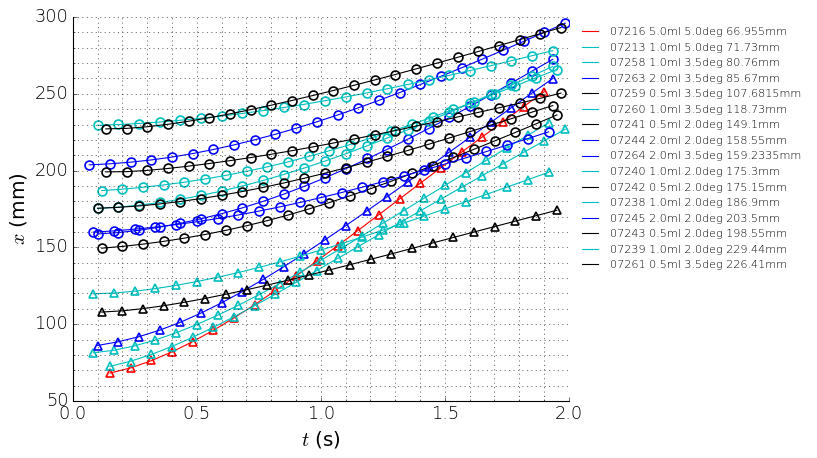

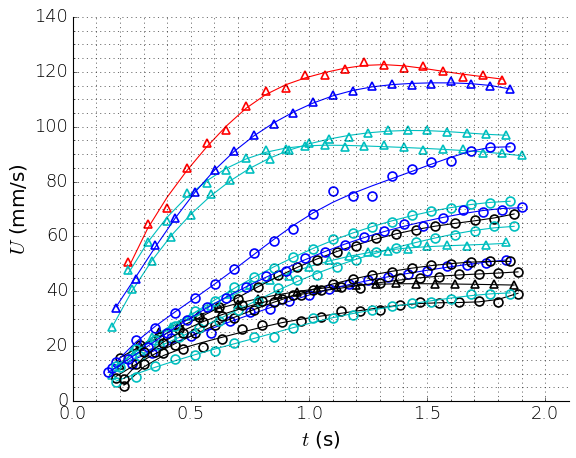

In [73]:
location = 'average'
volumes = [0.5,1.0,2.0,5.0]
angles= [2.0,3.5,5.0]

data = gen_data_repos(wrkdir,csv_files,trackdata,n_files)
meta = get_drop_vars(metadata)

#plot_data(data,meta,volumes,location)
[v_norm,x_max] = filtering_data(data,meta,volumes,angles,location)
xi_norm = normalized_variables(meta,data,location)
plt.show()


# Linear fit to data

In [43]:
xi_vector = np.zeros(n_files-1)
v_vector = np.zeros(n_files-1)
i = int(0)
for key in xi_norm:
    if key != '07261':
        xi_vector[i] = xi_norm[key]
        v_vector[i] = v_norm[key]
        i=i+1
    else:
         print()  
fit = np.polyfit(xi_vector,v_vector,1)
fit_fn = np.poly1d(fit)


# Non-dimenionalized plot: $U_{max}^*$ vs $x_i^*$

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


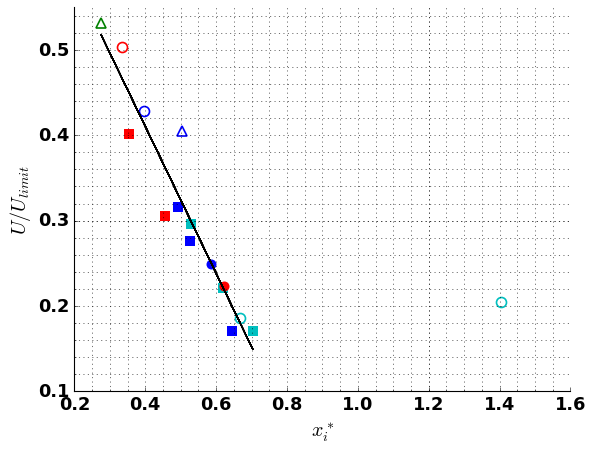

In [44]:
from matplotlib.lines import Line2D
v_max = ((4*0.072*9.81)/1000)**(1/4.)*1000
fig1 = plt.figure(facecolor="white")
for key in xi_norm:
    R = ((3000*meta[key]['Volume'])/(4*math.pi))**(1/3)
    sin_angl = math.sin((meta[key]['Angle']/2)*(math.pi/180))
    x_max_theo = (R/sin_angl)
    
    if x_max[key]>x_max_theo:
        fill = 'none'
        w = 1.5
      
    elif x_max[key]<=x_max_theo:
        fill = 'full'
        w=0
        
    if meta[key]['Angle']== 2.0:
        style = 's'
    elif meta[key]['Angle']== 3.5:
        style = 'o'
    elif meta[key]['Angle']== 5.0:
        style = '^'
        
    if meta[key]['Volume']== 0.5:
        clr = 'c'
    elif meta[key]['Volume']== 1.0:
        clr = 'b'
    elif meta[key]['Volume']== 2.0:
        clr = 'r'
    elif meta[key]['Volume']== 5.0:
        clr = 'g'
        

    ax = fig1.add_subplot(1,1,1) 
    basic_plot_format(subplot_label = ax, \
                      x_label = '$x_i^*$',  \
                      y_label = '$U/U_{limit}$', \
                      major_grid = True,  \
                      minor_grid = True,  \
                      legend = False
                     )
    ax.plot(xi_norm[key],v_norm[key]/v_max,\
                marker=style,\
                c = clr,\
                ms=9,\
                fillStyle=fill,\
                markeredgewidth=w
           )
    ax.plot(xi_vector,fit_fn(xi_vector)/v_max,'k')
  
    #ax.set_xlim([0,1])
    #ax.set_ylim([0,0.75])
    

fig1.savefig('Figures/dimensionalplot.png',dpi=300, bbox_inches='tight')
plt.show()

linear trend of max velocity? Non-dimensional parameter $x_i^* = x_i \sin\alpha(\frac{4 \pi}{3 V})^{1/3}  $ where $x_i$ is the initial location of the droplet relative to the wedge vertex, $V$ is the droplet volume, and $\alpha$ is the wedge half angle. $U_{limit}$ is found by thermodynamic principles of conservation of energy: negative difference in surface energy associated with confined and unconfined states is transferred to kinetic energy. Under limits of large volume small angle experiments, a theoretical velocity is found to be $U_{limit} = (\frac{\sigma g}{\rho})^{1/4}$